In [ ]:
# Data Manipulation and Numerical Libraries
import numpy as np
import pandas as pd
import random
import shutil

# Deep Learning Libraries (PyTorch)
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F
import torchvision.transforms.v2.functional as TF
from torchvision import models
import torch.optim as optim
# from lion_pytorch import Lion

# Data Preprocessing and Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    average_precision_score,
    roc_auc_score, roc_curve, auc
)
from tqdm import tqdm
from tqdm import trange
from ultralytics import YOLO
import optuna

# Image Processing and Visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns

# File I/O and XML Parsing
import os
from glob import glob
from pathlib import Path
from shutil import copy2
import json
import kagglehub
import csv

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# 전처리

In [3]:
cd /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02

/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02


In [ ]:
# 경로 설정 (사용자 맞춤 절대 경로)
ANNOTATIONS_DIR = Path("./Pills_OD_02/data/original/train_annotations")
IMAGES_DIR = Path("./Pills_OD_02/data/original/train_images")
TEST_IMAGE_DIR = Path("'./Pills_OD_02/data/original/test_images'")
OUTPUT_DIR = Path("./Pills_OD_02/data/yolo_model")

IMAGE_TRAIN = OUTPUT_DIR / 'images' / 'train'
IMAGE_VAL = OUTPUT_DIR / 'images' / 'val'

IMAGE_TEST = OUTPUT_DIR / 'images' / 'test'
IMAGE_TEST.mkdir(parents=True, exist_ok=True)

OUTPUT_LABEL = OUTPUT_DIR / "labels"   # 추가함
OUTPUT_LABEL.mkdir(parents=True, exist_ok=True)

LABEL_TRAIN = OUTPUT_DIR / "labels" / "train"
LABEL_VAL = OUTPUT_DIR / "labels" / "val"
DATA_YAML_PATH = OUTPUT_DIR / "data.yaml"

In [ ]:
# 테스트 이미지 복사
from distutils.dir_util import copy_tree
# for file in TEST_IMAGE_DIR.glob("*.png"):
    # shutil.copy(file, IMAGE_TEST / file.name)
copy_tree(TEST_IMAGE_DIR, IMAGE_TEST)

In [6]:
# COCO JSON 기준 클래스 정보 추출
sample_json = next(ANNOTATIONS_DIR.glob("**/*.json"))  # 하나의 예시 JSON을 기준으로 categories 수집
with open(sample_json, "r", encoding="utf-8") as f:
    sample_data = json.load(f)
categories = sample_data["categories"]
id_to_index = {cat["id"]: i for i, cat in enumerate(categories)}
index_to_name = {i: cat["name"] for i, cat in enumerate(categories)}

In [8]:
# YOLO 라벨 생성: 클래스는 전부 0 ('pill')
def yolo_labels():
    for img_path in IMAGES_DIR.glob("*.png"):
        img_stem = img_path.stem
        json_folder_name = img_stem.split('_')[0] + "_json"
        jsons_root = ANNOTATIONS_DIR / json_folder_name
        if not jsons_root.exists():
            continue

        pill_codes = json_folder_name.replace("_json", "").split('-')[1:]
        pill_folder_names = [f"K-{code}" for code in pill_codes]

        label_lines = []
        w, h = None, None

        for pill_folder_name in pill_folder_names:
            pill_folder = jsons_root / pill_folder_name
            json_file = pill_folder / (img_stem + ".json")
            if not json_file.exists():
                continue
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                if w is None or h is None:
                    w = data["images"][0]["width"]
                    h = data["images"][0]["height"]
                for ann in data.get("annotations", []):
                    x, y, bw, bh = ann["bbox"]
                    x_c = (x + bw/2) / w
                    y_c = (y + bh/2) / h
                    bw /= w
                    bh /= h
                    label_lines.append(f"0 {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")  # ← 클래스 0 고정

        # 라벨 저장
        out_txt = OUTPUT_LABEL / (img_stem + ".txt")
        with open(out_txt, "w", encoding="utf-8") as f:
            f.write("\n".join(label_lines))

In [9]:
# 학습/검증 디렉토리 생성
for d in [IMAGE_TRAIN, IMAGE_VAL, LABEL_TRAIN, LABEL_VAL]:
    d.mkdir(parents=True, exist_ok=True)

In [10]:
# 이미지와 라벨 쌍 복사 함수
# 이전 버전에서 복사 대상 폴더 안에 있는 파일을 다시 자기 자신에게 복사하여 간헐적으로 오류 발생하여 수정함.
def copy_dataset(image_list, img_dst_dir, label_dst_dir):
    for img_path in image_list:
        label_path = OUTPUT_LABEL / (img_path.stem + ".txt")  # 원본 라벨 경로
        dst_label_path = label_dst_dir / (img_path.stem + ".txt")  # 복사 대상 경로
        dst_img_path = img_dst_dir / img_path.name

        copy2(img_path, dst_img_path)
        print(f"[✓] Copied image: {img_path} → {dst_img_path}")

        if label_path.exists():
            copy2(label_path, dst_label_path)  # 원본 → 대상 복사
            print(f"[✓] Copied label: {label_path} → {dst_label_path}")
            
        else:
            open(dst_label_path, 'w').close()
            print(f"[✓] Copied label: {label_path} → {dst_label_path}")

In [11]:
def generate_data_yaml():
    content = f"""path: {OUTPUT_DIR.resolve()}
train: images/train
val: images/val
nc: 1
names: ['pill']"""
    with open(DATA_YAML_PATH, "w", encoding="utf-8") as f:
        f.write(content)

In [ ]:
def add_gaussian_noise(image, mean=0, std=25):
    gauss = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = image.astype(np.float32) + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# 이미지에 노이즈 적용 후 저장
def apply_gaussian_noise_to_images(input_dir, output_dir):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for img_path in tqdm(sorted(input_dir.glob("*.png")), desc=f"Adding Gaussian noise"):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"[!] 이미지 읽기 실패: {img_path.name}")
            continue
        noised_img = add_gaussian_noise(img)
        cv2.imwrite(str(output_dir / img_path.name), noised_img)

In [ ]:
def run():
    yolo_labels()

    all_images = list(IMAGES_DIR.glob("*.png"))
    random.shuffle(all_images)

    val_ratio = 0.2
    val_cnt = int(len(all_images) * val_ratio)
    val_images = set(all_images[:val_cnt])
    train_images = set(all_images[val_cnt:])

    copy_dataset(train_images, IMAGE_TRAIN, LABEL_TRAIN)
    copy_dataset(val_images, IMAGE_VAL, LABEL_VAL)
    
    apply_gaussian_noise_to_images(IMAGE_TRAIN, NOISE_IMAGE_TRAIN)
    copy_labels(LABEL_TRAIN, NOISE_LABEL_TRAIN)
    
    generate_data_yaml()

    print(f"\n✓ 변환 완료: {len(train_images)} train, {len(val_images)} val")
    print(f"✓ data.yaml 생성 완료: {DATA_YAML_PATH}")

if __name__ == "__main__":
    run()

[✓] Copied image: data/original/train_images/K-003483-022347-027653-035206_0_2_0_2_90_000_200.png → data/yolo_model/images/train/K-003483-022347-027653-035206_0_2_0_2_90_000_200.png
[✓] Copied label: data/yolo_model/labels/K-003483-022347-027653-035206_0_2_0_2_90_000_200.txt → data/yolo_model/labels/train/K-003483-022347-027653-035206_0_2_0_2_90_000_200.txt
[✓] Copied image: data/original/train_images/K-003483-022347-027733-029667_0_2_0_2_75_000_200.png → data/yolo_model/images/train/K-003483-022347-027733-029667_0_2_0_2_75_000_200.png
[✓] Copied label: data/yolo_model/labels/K-003483-022347-027733-029667_0_2_0_2_75_000_200.txt → data/yolo_model/labels/train/K-003483-022347-027733-029667_0_2_0_2_75_000_200.txt
[✓] Copied image: data/original/train_images/K-003351-016688-018357_0_2_0_2_75_000_200.png → data/yolo_model/images/train/K-003351-016688-018357_0_2_0_2_75_000_200.png
[✓] Copied label: data/yolo_model/labels/K-003351-016688-018357_0_2_0_2_75_000_200.txt → data/yolo_model/labels/

## 수동 라벨링 후의 라벨로 교체

In [ ]:
image_names = {img.stem for img in IMAGE_TRAIN.glob("*.png")}
label_names = {txt.stem for txt in LABEL_TRAIN.glob("*.txt")}

matched = image_names & label_names
unmatched = label_names - image_names

print(f"이미지 수: {len(image_names)}")
print(f"라벨 수: {len(label_names)}")
print(f"정확히 매칭된 수: {len(matched)}")
print(f"이미지 없는 라벨 수: {len(unmatched)}")

이미지 수: 1192
라벨 수: 1192
정확히 매칭된 수: 1192
이미지 없는 라벨 수: 0


In [ ]:
image_names = {img.stem for img in IMAGE_VAL.glob("*.png")}
label_names = {txt.stem for txt in LABEL_VAL.glob("*.txt")}

matched = image_names & label_names
unmatched = label_names - image_names

print(f"이미지 수: {len(image_names)}")
print(f"라벨 수: {len(label_names)}")
print(f"정확히 매칭된 수: {len(matched)}")
print(f"이미지 없는 라벨 수: {len(unmatched)}")

이미지 수: 297
라벨 수: 297
정확히 매칭된 수: 297
이미지 없는 라벨 수: 0


In [ ]:
def replace_labels(image_dir, new_label_dir, target_label_dir):
    image_paths = list(Path(image_dir).glob("*.png"))
    count = 0

    for img_path in tqdm(image_paths, desc=f"{image_dir.name} 라벨 교체 중"):
        txt_name = img_path.with_suffix(".txt").name
        new_txt_path = new_label_dir / txt_name
        target_txt_path = target_label_dir / txt_name

        if new_txt_path.exists():
            try:
                with open(new_txt_path, "r") as f:
                    lines = f.readlines()

                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        # class_id를 0으로 변경하고 나머지는 유지
                        new_line = f"0 {parts[1]} {parts[2]} {parts[3]} {parts[4]}\n"
                        new_lines.append(new_line)

                # 변경된 라벨을 target에 저장
                with open(target_txt_path, "w") as f:
                    f.writelines(new_lines)

                count += 1
            except Exception as e:
                print(f"[!] {txt_name} 처리 중 오류 발생: {e}")
        else:
            print(f"[!] new_labels에 없음: {txt_name}")

    print(f"\n총 {count}개 라벨이 교체 완료됨!")

# 경로 설정
NEW_LABELS = Path("./data/new_labels")  # 폴더 하나만 존재

# 교체 실행
replace_labels(IMAGE_TRAIN, NEW_LABELS, LABEL_TRAIN)
replace_labels(IMAGE_VAL, NEW_LABELS, LABEL_VAL)

train 라벨 교체 중: 100%|██████████| 1192/1192 [00:00<00:00, 3911.38it/s]



총 1192개 라벨이 교체 완료됨!


val 라벨 교체 중: 100%|██████████| 297/297 [00:00<00:00, 3307.71it/s]


총 297개 라벨이 교체 완료됨!


# YOLO

In [5]:
# YOLO 프로젝트 폴더로 이동
os.chdir('./data/yolo_model')
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/yolo_model


In [ ]:
# 모델 불러오기
model = YOLO("yolov8n.pt")

model.train(
    data='data.yaml',
    epochs=50,
    imgsz=(1280, 976),
    batch=8,
    degrees=5,           # 회전
    # translate=0.1,       # 평행이동
    # scale=0.3,           # 크기 변경
    # shear=2.0,           # 기울이기
    # flipud=0.1,          # 상하 반전
    # fliplr=0.3,          # 좌우 반전
    # hsv_s=0.3,           # 채도 변화
    # hsv_v=0.3,           # 명도 변화
    mosaic=0.6,          # Mosaic 합성
    # mixup=0.1,           # Mixup
    name="pill_yolo8_train",
    project="runs/detect",
    # device=device.
    save=True
)

New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.8.18 torch-2.4.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=5, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.3, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.3, imgsz=(1280, 976), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.4, multi_scale=False, name=pill_yolo8_train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

Fontconfig warning: ignoring UTF-8: not a valid region tag


Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ updating to 'imgsz=1280'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1625.6±307.3 MB/s, size: 1850.0 KB)


train: Scanning /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/yolo_model/labels/train.cache... 1192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1192/1192 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1554.6±99.3 MB/s, size: 1801.9 KB)


val: Scanning /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/yolo_model/labels/val.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]

Plotting labels to runs/detect/pill_yolo8_train7/labels.jpg... 


WARNING ⚠️ 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/detect/pill_yolo8_train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.128      3.435      3.181         32       1280:   1%|          | 1/149 [00:10<27:01, 10.95s/it]

In [ ]:
model = YOLO("./runs/detect/yolo_e100_01/runs/detect/pill_yolo8_train/weights/best.pt")  # 학습된 모델
metrics = model.val(data="./runs/detect/yolo_e100_01/data.yaml")

# YOLOv8 -> crop 및 ResNet 입력용 이미지 생성

In [ ]:
cd ../

In [ ]:
# 경로 설정
YOLO_WEIGHTS = './yolo_model/runs/detect/pill_yolo8_train/weights/best.pt'
MODEL_RESNET = Path('./resnet_model')
MODEL_RESNET.mkdir(parents=True, exist_ok=True)

CROP_OUTPUT_DIR = MODEL_RESNET / "cropped_imgs"  # Crop된 이미지 저장 폴더
CROP_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CROP_TRAIN = CROP_OUTPUT_DIR / "train"  # Crop된 이미지 저장 폴더
CROP_TRAIN.mkdir(parents=True, exist_ok=True)

CROP_VAL = CROP_OUTPUT_DIR / "val"  # Crop된 이미지 저장 폴더
CROP_VAL.mkdir(parents=True, exist_ok=True)

FAIL_TRAIN = CROP_OUTPUT_DIR / "fail_train"  # Crop된 매칭 실패 이미지 저장 폴더
FAIL_TRAIN.mkdir(parents=True, exist_ok=True)

FAIL_VAL = CROP_OUTPUT_DIR / "fail_val"  # Crop된 매칭 실패 이미지 저장 폴더
FAIL_VAL.mkdir(parents=True, exist_ok=True)



In [7]:
yolov8_model = YOLO(YOLO_WEIGHTS)

In [8]:
def crop_and_label(image_dir, crop_output_dir, csv_output_path, crop_dir_fail, annotations_dir, fail_csv_output_path):
    records_success = []
    records_fail = []
    crop_label_map = {}

    for img_path in sorted(Path(image_dir).glob("*.png")):
        print(f"\n[*] Processing: {img_path.name}")
        results = yolov8_model.predict(str(img_path), save=False, imgsz=(640, 512))
        boxes = results[0].boxes

        if boxes is None or len(boxes) == 0:
            print(f"[!] No detection boxes found in image: {img_path.name}")
            continue

        image = cv2.imread(str(img_path))
        if image is None:
            print(f"[!] Failed to read image: {img_path}")
            continue

        print(f"[+] Found {len(boxes)} boxes.")

        for i, box in enumerate(boxes):
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            print(f"  → YOLO pred bbox: {xyxy.tolist()}")
            
            cropped = image[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
            save_name = f"{img_path.stem}_{i}.png"

            cls_id, cls_name, iou = get_class_from_json(img_path.stem, xyxy, annotations_dir)

            if cls_id == -1:
                save_path = crop_dir_fail / save_name
                cv2.imwrite(str(save_path), cropped)
                print(f"  → Failed match. Saved to FAIL: {save_name}")
                records_fail.append([save_name, -1, "Unknown", *xyxy, img_path.name, 0.0])
                continue

            save_path = crop_output_dir / save_name
            cv2.imwrite(str(save_path), cropped)
            print(f"  → Saved {save_name} (class: ({cls_id}, '{cls_name}'))")
            crop_label_map[save_name] = cls_id
            # iou = best_iou  # get_class_from_json 함수에서 반환
            records_success.append([save_name, cls_id, cls_name, *xyxy, img_path.name, round(iou, 4)])  

    # 성공 CSV 저장
    with open(csv_output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_name", "class_id", "class_name", "x1", "y1", "x2", "y2", "original_image", "iou_score"])
        writer.writerows(records_success)

    # 실패 CSV 저장 (디렉토리 아닌 실제 파일 경로 사용)
    with open(fail_csv_output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_name", "class_id", "x1", "y1", "x2", "y2", "original_image", "iou_score"])
        writer.writerows(records_fail)

    return crop_label_map

In [ ]:
def get_class_from_json(image_stem, pred_bbox, annotations_dir, iou_threshold=0.1):
    import json
    from pathlib import Path

    target_base = image_stem.split('.')[0]
    all_json_files = list(Path(annotations_dir).rglob("*.json"))

    for json_file in all_json_files:
        try:
            with open(json_file, "r") as f:
                coco = json.load(f)
        except Exception as e:
            print(f"[!] Failed to read {json_file.name}: {e}")
            continue

        images = coco.get("images", [])
        anns = coco.get("annotations", [])
        categories = coco.get("categories", [])
        cat_id_to_name = {cat["id"]: cat["name"] for cat in categories}

        # 이미지 매칭
        matched_imgs = [img for img in images if img.get("file_name", "").startswith(target_base)]
        if not matched_imgs:
            continue

        img_id = matched_imgs[0]["id"]
        matched_anns = [ann for ann in anns if ann.get("image_id") == img_id]

        def compute_iou(boxA, boxB):
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])
            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
            boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
            if boxAArea + boxBArea - interArea == 0:
                return 0.0
            iou = interArea / (boxAArea + boxBArea - interArea)
            return iou

        best_iou = 0
        best_class_id = -1

        for ann in matched_anns:
            x, y, w, h = ann["bbox"]
            ann_bbox = [x, y, x + w, y + h]  # (x, y, w, h) → (x1, y1, x2, y2) 변환
            iou = compute_iou(pred_bbox, ann_bbox)
            print(f"[IOU] {image_stem} pred vs ann {ann_bbox}: {iou:.4f}")

            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_class_id = ann["category_id"]

        if best_class_id != -1:
            class_name = cat_id_to_name.get(best_class_id, "Unknown")
            return best_class_id, class_name, best_iou

    print(f"[!] No match for {image_stem}")
    return -1, "Unknown", 0.0


In [48]:
crop_and_label(
    image_dir = IMAGE_TRAIN,
    crop_output_dir = CROP_TRAIN,
    csv_output_path = MODEL_RESNET / "predicted_train.csv",
    crop_dir_fail = FAIL_TRAIN,  # 실패 이미지 디렉토리
    annotations_dir = ANNOTATIONS_DIR,
    fail_csv_output_path = MODEL_RESNET / "predicted_train_fail.csv"  # 실패 CSV
)


[*] Processing: K-001900-010224-016551-031705_0_2_0_2_70_000_200.png

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/yolo_model/images/train/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png: 640x512 4 pills, 459.8ms
Speed: 5.7ms preprocess, 459.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)
[+] Found 4 boxes.
  → YOLO pred bbox: [152, 746, 400, 1168]
[IOU] K-001900-010224-016551-031705_0_2_0_2_70_000_200 pred vs ann [645, 859, 855, 1017]: 0.0000
[IOU] K-001900-010224-016551-031705_0_2_0_2_70_000_200 pred vs ann [134, 123, 379, 549]: 0.0000
[IOU] K-001900-010224-016551-031705_0_2_0_2_70_000_200 pred vs ann [566, 131, 851, 581]: 0.0000
[!] No match for K-001900-010224-016551-031705_0_2_0_2_70_000_200
  → Failed match. Saved to FAIL: K-001900-010224-016551-031705_0_2_0_2_70_000_200_0.png
  → YOLO pred bbox: [566, 123, 848, 588]
[IOU] K-001900-010224-016551-031705_0_2_0_2_70_000_200 pred vs ann [645, 859, 855, 1017]: 0.0000
[IOU] K-00190

{'K-001900-010224-016551-031705_0_2_0_2_70_000_200_1.png': 16550,
 'K-001900-010224-016551-031705_0_2_0_2_70_000_200_2.png': 31704,
 'K-001900-010224-016551-031705_0_2_0_2_70_000_200_3.png': 1899,
 'K-001900-010224-016551-031705_0_2_0_2_75_000_200_0.png': 16550,
 'K-001900-010224-016551-031705_0_2_0_2_75_000_200_3.png': 1899,
 'K-001900-010224-016551-031705_0_2_0_2_90_000_200_0.png': 31704,
 'K-001900-010224-016551-031705_0_2_0_2_90_000_200_1.png': 16550,
 'K-001900-010224-016551-031705_0_2_0_2_90_000_200_3.png': 1899,
 'K-001900-010224-016551-033009_0_2_0_2_70_000_200_2.png': 1899,
 'K-001900-010224-016551-033009_0_2_0_2_70_000_200_3.png': 33008,
 'K-001900-010224-016551-033009_0_2_0_2_75_000_200_1.png': 16550,
 'K-001900-010224-016551-033009_0_2_0_2_75_000_200_3.png': 1899,
 'K-001900-010224-016551-033009_0_2_0_2_90_000_200_0.png': 16550,
 'K-001900-010224-016551-033009_0_2_0_2_90_000_200_2.png': 33008,
 'K-001900-010224-016551-033009_0_2_0_2_90_000_200_3.png': 1899,
 'K-001900-01654

In [49]:
crop_and_label(
    image_dir=IMAGE_VAL,
    crop_output_dir=CROP_VAL,
    csv_output_path=MODEL_RESNET / "predicted_val.csv",
    crop_dir_fail=FAIL_VAL,  # 실패 이미지 디렉토리
    annotations_dir=ANNOTATIONS_DIR,
    fail_csv_output_path=MODEL_RESNET / "predicted_val_fail.csv"  # 실패 CSV
)


[*] Processing: K-001900-016548-018110-021026_0_2_0_2_70_000_200.png

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/yolo_model/images/val/K-001900-016548-018110-021026_0_2_0_2_70_000_200.png: 640x512 4 pills, 116.1ms
Speed: 4.1ms preprocess, 116.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)
[+] Found 4 boxes.
  → YOLO pred bbox: [632, 842, 941, 1152]
[IOU] K-001900-016548-018110-021026_0_2_0_2_70_000_200 pred vs ann [140, 866, 380, 1106]: 0.0000
[IOU] K-001900-016548-018110-021026_0_2_0_2_70_000_200 pred vs ann [173, 279, 374, 420]: 0.0000
[IOU] K-001900-016548-018110-021026_0_2_0_2_70_000_200 pred vs ann [674, 274, 850, 447]: 0.0000
[IOU] K-001900-016548-018110-021026_0_2_0_2_70_000_200 pred vs ann [628, 845, 951, 1151]: 0.9448
  → Saved K-001900-016548-018110-021026_0_2_0_2_70_000_200_0.png (class: (18109, '란스톤엘에프디티정 30mg'))
  → YOLO pred bbox: [140, 864, 381, 1110]
[IOU] K-001900-016548-018110-021026_0_2_0_2_70_000_200 pred vs ann [

{'K-001900-016548-018110-021026_0_2_0_2_70_000_200_0.png': 18109,
 'K-001900-016548-018110-021026_0_2_0_2_70_000_200_1.png': 16547,
 'K-001900-016548-018110-021026_0_2_0_2_70_000_200_2.png': 21025,
 'K-001900-016548-018110-021026_0_2_0_2_70_000_200_3.png': 1899,
 'K-001900-016548-018110-021026_0_2_0_2_75_000_200_0.png': 16547,
 'K-001900-016548-018110-021026_0_2_0_2_75_000_200_1.png': 18109,
 'K-001900-016548-018110-021026_0_2_0_2_75_000_200_2.png': 21025,
 'K-001900-016548-018110-021026_0_2_0_2_75_000_200_3.png': 1899,
 'K-001900-016548-018110-027926_0_2_0_2_70_000_200_0.png': 18109,
 'K-001900-016548-018110-027926_0_2_0_2_70_000_200_1.png': 27925,
 'K-001900-016548-018110-027926_0_2_0_2_70_000_200_3.png': 1899,
 'K-001900-016548-018110-029451_0_2_0_2_75_000_200_0.png': 16547,
 'K-001900-016548-018110-029451_0_2_0_2_75_000_200_1.png': 29450,
 'K-001900-016548-018110-029451_0_2_0_2_75_000_200_2.png': 18109,
 'K-001900-016548-018110-029451_0_2_0_2_75_000_200_3.png': 1899,
 'K-001900-016

# ResNet

In [ ]:
{0: '가바토파정 100mg',
 1: '글리아타민연질캡슐',
 2: '글리틴정(콜린알포세레이트)',
 3: '기넥신에프정(은행엽엑스)(수출용)',
 4: '낙소졸정 500/20mg',
 5: '노바스크정 5mg',
 6: '놀텍정 10mg',
 7: '뉴로메드정(옥시라세탐)',
 8: '다보타민큐정 10mg/병',
 9: '동아가바펜틴정 800mg',
 10: '라비에트정 20mg',
 11: '란스톤엘에프디티정 30mg',
 12: '레일라정',
 13: '렉사프로정 15mg',
 14: '로수바미브정 10/20mg',
 15: '로수젯정10/5밀리그램',
 16: '리렉스펜정 300mg/PTP',
 17: '리리카캡슐 150mg',
 18: '리바로정 4mg',
 19: '리피로우정 20mg',
 20: '리피토정 20mg',
 21: '마도파정',
 22: '맥시부펜이알정 300mg',
 23: '메가파워정 90mg/병',
 24: '무코스타정(레바미피드)(비매품)',
 25: '뮤테란캡슐 100mg',
 26: '보령부스파정 5mg',
 27: '브린텔릭스정 20mg',
 28: '비모보정 500/20mg',
 29: '비타비백정 100mg/병',
 30: '삐콤씨에프정 618.6mg/병',
 31: '삼남건조수산화알루미늄겔정',
 32: '세비카정 10/40mg',
 33: '스토가정 10mg',
 34: '신바로정',
 35: '써스펜8시간이알서방정 650mg',
 36: '쎄로켈정 100mg',
 37: '아모잘탄정 5/100mg',
 38: '아빌리파이정 10mg',
 39: '아질렉트정(라사길린메실산염)',
 40: '아토르바정 10mg',
 41: '아토젯정 10/40mg',
 42: '알드린정',
 43: '에빅사정(메만틴염산염)(비매품)',
 44: '에스원엠프정 20mg',
 45: '에어탈정(아세클로페낙)',
 46: '엑스포지정 5/160mg',
 47: '오마코연질캡슐(오메가-3-산에틸에스테르90)',
 48: '울트라셋이알서방정',
 49: '일양하이트린정 2mg',
 50: '자누메트엑스알서방정 100/1000mg',
 51: '자누메트정 50/850mg',
 52: '자누비아정 50mg',
 53: '자이프렉사정 2.5mg',
 54: '제미메트서방정 50/1000mg',
 55: '조인스정 200mg',
 56: '졸로푸트정 100mg',
 57: '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0',
 58: '카나브정 60mg',
 59: '카발린캡슐 25mg',
 60: '케이캡정 50mg',
 61: '콜리네이트연질캡슐 400mg',
 62: '쿠에타핀정 25mg',
 63: '큐시드정 31.5mg/PTP',
 64: '크레스토정 20mg',
 65: '타이레놀이알서방정(아세트아미노펜)(수출용)',
 66: '타이레놀정500mg',
 67: '트라젠타듀오정 2.5/850mg',
 68: '트라젠타정(리나글립틴)',
 69: '트루비타정 60mg/병',
 70: '트윈스타정 40/5mg',
 71: '펠루비정(펠루비프로펜)',
 72: '플라빅스정 75mg'}

### 데이터셋 구성

In [ ]:
class ResnetCustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_to_idx, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx  # class_name → index 매핑

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['image_name'])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        class_name = self.data.iloc[idx]['class_name']
        label = self.class_to_idx[class_name]  # 0~N 인덱스로 매핑
        
        return image, label

In [ ]:
# 데이터 로드
train_df = pd.read_csv('./resnet_model/predicted_train.csv')
val_df = pd.read_csv('./resnet_model/predicted_val.csv')

In [11]:
class_names = sorted(train_df['class_name'].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

### 데이터 증강 및 전처리

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=(3,5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    # AddGaussianNoise(0., 0.05),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [14]:
num_classes = len(class_to_idx)
num_classes

73

In [ ]:
train_dataset = ResnetCustomDataset(
    csv_file="./resnet_model/predicted_train.csv",
    img_dir="./resnet_model/cropped_imgs/train",
    class_to_idx=class_to_idx,
    transform=transform_train
)

val_dataset = ResnetCustomDataset(
    csv_file="./resnet_model/predicted_val.csv",
    img_dir="./resnet_model/cropped_imgs/val",
    class_to_idx=class_to_idx,
    transform=transform_val
)

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

## ResNet-50 모델

### 모델 로드

In [ ]:
# resnet101 모델 로드
resnet101_model = models.resnet101(pretrained=True)

# 마지막 FC 레이어 교체
resnet101_model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(resnet101_model.fc.in_features, num_classes)
)

# 전체 레이어 학습 가능하게 설정 (Full Unfreeze)
for param in resnet101_model.parameters():
    param.requires_grad = True

# GPU로 이동
resnet101_model = resnet101_model.to(device)

/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
resnet101_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet101_model.parameters(), lr=5e-5)
images, labels = next(iter(train_loader))

### 실험 코드

#### 하이퍼 파라미터 실험 | Bayesian Optimization

In [ ]:
def train_and_evaluate(trial):
    # 최적화할 하이퍼파라미터
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # DataLoader (trial에 따라 배치 사이즈 조정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 모델 준비
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    best_val_accuracy = 0.0

    for epoch in trange(3, desc="Tuning Epochs"):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val", leave=False):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

    return best_val_accuracy  # 이 값을 기준으로 Optuna가 평가


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(train_and_evaluate, n_trials=10)

print("Optuna 최적화 완료")
print("Best Validation Accuracy:", study.best_trial.value)
print("Best Hyperparameters:", study.best_trial.params)

#### fine-tuning 실험

In [ ]:
experiments = [
    {"name": "baseline_fc_clean", "freeze": "fc_only", "transform": "clean", "lr": 1e-3, "loss": "ce"},
    {"name": "ft_partial_noisy", "freeze": "layer4", "transform": "noisy", "lr": 1e-4, "loss": "ce"},
    {"name": "ft_full_mixed", "freeze": "all", "transform": "mixed", "lr": 5e-5, "loss": "ce"},
    {"name": "ft_partial_clean_ls", "freeze": "layer4", "transform": "clean", "lr": 1e-4, "loss": "label_smoothing"},
    {"name": "ft_partial_noisy_focal", "freeze": "layer4", "transform": "noisy", "lr": 1e-4, "loss": "focal"},
]

In [ ]:
for exp in experiments:
    print(f"\n--- Running Experiment: {exp['name']} ---")

    transform_train = get_transform(exp['transform'])
    transform_val = get_transform('clean')

    train_dataset = ResnetCustomDataset(
        csv_file="./resnet_model/predicted_train.csv",
        img_dir="./resnet_model/cropped_imgs/train",
        class_to_idx=class_to_idx,
        transform=transform_train
    )
    val_dataset = ResnetCustomDataset(
        csv_file="./resnet_model/predicted_val.csv",
        img_dir="./resnet_model/cropped_imgs/val",
        class_to_idx=class_to_idx,
        transform=transform_val
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = get_model(num_classes=len(class_to_idx), freeze_type=exp['freeze'])
    model = model.to(device)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=exp['lr'])
    criterion = get_criterion(exp['loss'])


    resnet50_model, train_losses, train_accuracies, val_losses, val_accuracies, final_preds, final_labels, final_outputs = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=20)
    # 모델 학습 결과 시각화
    plot_train_val_metrics(train_losses, val_losses, train_accuracies, val_accuracies, experiment_name=exp['name'])

    # ROC_AUC 출력
    ROC_AUC(final_preds,final_labels,final_outputs)
    
    # confusion matrix 및 리포트 출력
    show_confusion_matrix_and_report(final_preds, final_labels, class_names=list(class_to_idx.keys()))    


### 평가지표

In [ ]:
def topk_accuracy(output, target, topk=(1,5)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # (batch_size, maxk)
    pred = pred.t()  # (maxk, batch_size)
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

### EarlyStopping

In [ ]:
# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, save_path='./resnet_model/best_es_resnet.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(model)
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            print(f"count: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        print(f"{self.save_path}에 모델 가중치 저장됨")


## 학습

In [ ]:
early_stopper = EarlyStopping(patience=5, save_path='./resnet_model/best_es_resnet.pth')

In [38]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 최종 평가용
final_preds = []
final_labels = []
final_outputs = []

for epoch in trange(epochs, desc="Epochs"):
    resnet101_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet101_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total * 100
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation
    resnet101_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet101_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            final_preds.append(predicted.cpu())
            final_labels.append(labels.cpu())
            final_outputs.append(outputs.cpu())

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total * 100
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% "
          f"| Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")
    
    
    # EarlyStopping
    early_stopper(epoch_val_acc, resnet101_model)
    if early_stopper.early_stop:
        print("**Early stopping triggered**")
        break

Epochs:   3%|▎         | 1/30 [05:14<2:32:07, 314.72s/it]

[Epoch 1] Train Loss: 0.0044 | Train Acc: 99.94% | Val Loss: 0.0472 | Val Acc: 99.67%
count: 1/5


Epochs:   7%|▋         | 2/30 [10:42<2:30:32, 322.57s/it]

[Epoch 2] Train Loss: 0.0032 | Train Acc: 99.92% | Val Loss: 0.0411 | Val Acc: 99.67%
count: 2/5


[Epoch 3] Train Loss: 0.0051 | Train Acc: 99.92% | Val Loss: 0.0494 | Val Acc: 99.89%


Epochs:  10%|█         | 3/30 [16:15<2:27:18, 327.35s/it]

/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/resnet_model/best_resnet101_01.pth에 모델 가중치 저장됨


[Epoch 4] Train Loss: 0.0021 | Train Acc: 99.94% | Val Loss: 0.0466 | Val Acc: 99.89%


Epochs:  13%|█▎        | 4/30 [21:48<2:22:41, 329.30s/it]

/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/resnet_model/best_resnet101_01.pth에 모델 가중치 저장됨


Epochs:  17%|█▋        | 5/30 [27:20<2:17:42, 330.49s/it]

[Epoch 5] Train Loss: 0.0018 | Train Acc: 99.97% | Val Loss: 0.0463 | Val Acc: 99.56%
count: 1/5


Epochs:  20%|██        | 6/30 [32:52<2:12:22, 330.96s/it]

[Epoch 6] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.0501 | Val Acc: 99.56%
count: 2/5


[Epoch 7] Train Loss: 0.0060 | Train Acc: 99.86% | Val Loss: 0.0427 | Val Acc: 99.89%


Epochs:  23%|██▎       | 7/30 [38:26<2:07:10, 331.77s/it]

/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/resnet_model/best_resnet101_01.pth에 모델 가중치 저장됨


Epochs:  27%|██▋       | 8/30 [43:59<2:01:48, 332.23s/it]

[Epoch 8] Train Loss: 0.0052 | Train Acc: 99.89% | Val Loss: 0.0467 | Val Acc: 99.56%
count: 1/5


Epochs:  30%|███       | 9/30 [49:33<1:56:31, 332.94s/it]

[Epoch 9] Train Loss: 0.0023 | Train Acc: 99.94% | Val Loss: 0.0504 | Val Acc: 99.56%
count: 2/5


[Epoch 10] Train Loss: 0.0028 | Train Acc: 99.97% | Val Loss: 0.0408 | Val Acc: 99.89%


Epochs:  33%|███▎      | 10/30 [55:07<1:51:01, 333.08s/it]

/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/resnet_model/best_resnet101_01.pth에 모델 가중치 저장됨


Epochs:  37%|███▋      | 11/30 [1:00:41<1:45:35, 333.43s/it]

[Epoch 11] Train Loss: 0.0050 | Train Acc: 99.92% | Val Loss: 0.0472 | Val Acc: 99.67%
count: 1/5


Epochs:  40%|████      | 12/30 [1:06:18<1:40:21, 334.55s/it]

[Epoch 12] Train Loss: 0.0030 | Train Acc: 99.92% | Val Loss: 0.0437 | Val Acc: 99.56%
count: 2/5


Epochs:  43%|████▎     | 13/30 [1:11:50<1:34:35, 333.85s/it]

[Epoch 13] Train Loss: 0.0043 | Train Acc: 99.94% | Val Loss: 0.0455 | Val Acc: 99.56%
count: 3/5


Epochs:  47%|████▋     | 14/30 [1:17:16<1:28:24, 331.52s/it]

[Epoch 14] Train Loss: 0.0059 | Train Acc: 99.89% | Val Loss: 0.1861 | Val Acc: 97.57%
count: 4/5


Epochs:  47%|████▋     | 14/30 [1:22:44<1:34:34, 354.64s/it]

[Epoch 15] Train Loss: 0.0059 | Train Acc: 99.89% | Val Loss: 0.0474 | Val Acc: 99.78%
count: 5/5
**Early stopping triggered**


## 결과 확인

In [39]:
all_preds = torch.cat(final_preds)
all_labels = torch.cat(final_labels)
all_outputs = torch.cat(final_outputs)

# TorchMetrics
f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
precision = MulticlassPrecision(num_classes=num_classes, average='macro')
recall = MulticlassRecall(num_classes=num_classes, average='macro')
confmat = MulticlassConfusionMatrix(num_classes=num_classes)

f1_val = f1(all_preds, all_labels).item()
precision_val = precision(all_preds, all_labels).item()
recall_val = recall(all_preds, all_labels).item()
confmat_val = confmat(all_preds, all_labels).cpu().numpy()

print(f"F1 Score: {f1_val:.4f} | Precision: {precision_val:.4f} | Recall: {recall_val:.4f}")
print(f"Confusion Matrix:\n{confmat_val}")

# Top-k Accuracy
top1_acc, top5_acc = topk_accuracy(all_outputs, all_labels, topk=(1,5))
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels.numpy(), all_preds.numpy(), digits=4))

F1 Score: 0.9927 | Precision: 0.9905 | Recall: 0.9966
Confusion Matrix:
[[495   0   0 ...   0   0   0]
 [  0  60   0 ...   0   0   0]
 [  0   0  30 ...   0   0   0]
 ...
 [  0   0   0 ... 225   0   0]
 [  0   0   0 ...   0 210   0]
 [  0   0   0 ...   0   0 180]]
Top-1 Accuracy: 99.55%
Top-5 Accuracy: 99.89%

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9706    0.9851       510
           1     1.0000    1.0000    1.0000        60
           2     1.0000    1.0000    1.0000        30
           3     1.0000    1.0000    1.0000      1380
           4     1.0000    1.0000    1.0000       150
           5     1.0000    1.0000    1.0000       195
           6     1.0000    1.0000    1.0000       120
           7     0.6000    1.0000    0.7500        30
           8     1.0000    1.0000    1.0000       105
           9     1.0000    1.0000    1.0000       510
          10     1.0000    1.0000    1.0000        75
          11     

In [40]:
# ROC-AUC
num_classes = all_outputs.size(1)
all_labels_onehot = F.one_hot(all_labels, num_classes=num_classes).numpy()
all_probs = F.softmax(all_outputs, dim=1).numpy()
try:
    roc_auc = roc_auc_score(all_labels_onehot, all_probs, average='macro', multi_class='ovr')
    print(f"ROC-AUC (macro, OvR): {roc_auc:.4f}")
except Exception as e:
    print("ROC-AUC 계산 중 오류 발생:", e)

ROC-AUC (macro, OvR): 0.9996


In [ ]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

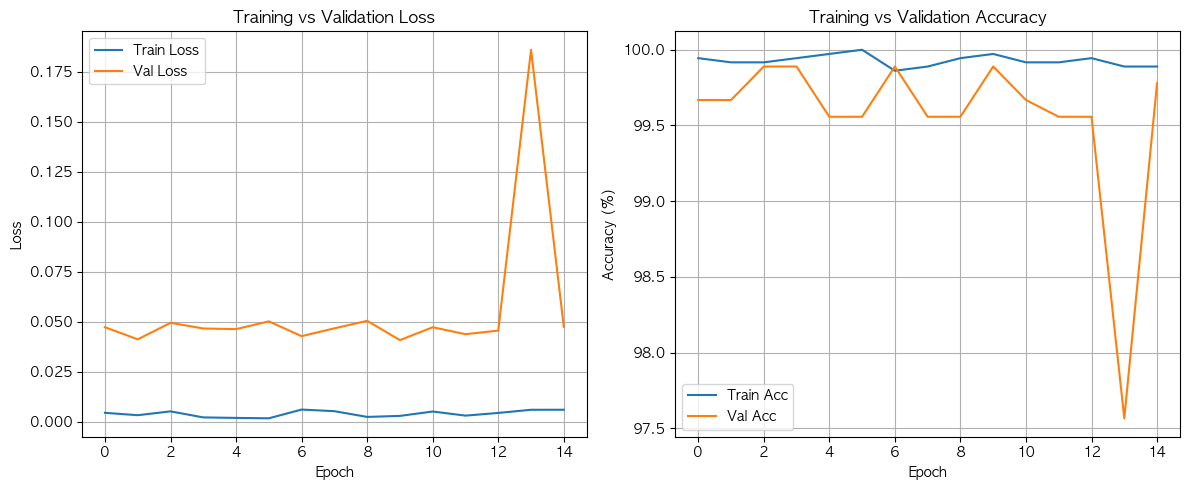

In [45]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 오버피팅 확인

In [ ]:
overfitting_gap = val_losses[13] - train_losses[13]
overfitting_gap

0.18023707284604848

In [ ]:
overfitting_gap = val_accuracies[13] - train_accuracies[13]
overfitting_gap

## 가중치 저장 & 불러오기

In [ ]:
torch.save(resnet101_model.state_dict(), "./resnet_model/resnet_model_R14.pth")

In [ ]:
# 학습된 가중치 불러오기
resnet101_model.load_state_dict(torch.load(".resnet_model/resnet_model_R14.pth"))
resnet101_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 시각화

In [54]:
def visualize_predictions(model, dataset, class_names, device, num_images=16):
    model.eval()
    fig = plt.figure(figsize=(12, 12))

    indices = np.random.choice(len(dataset), size=num_images, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_label].item()

        ax = fig.add_subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i+1)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')

        true_cls = class_names[label]
        pred_cls = class_names[pred_label]

        title_color = "green" if label == pred_label else "red"
        ax.set_title(f"P: {pred_cls}\nT: {true_cls}\nConf: {confidence:.2f}", color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

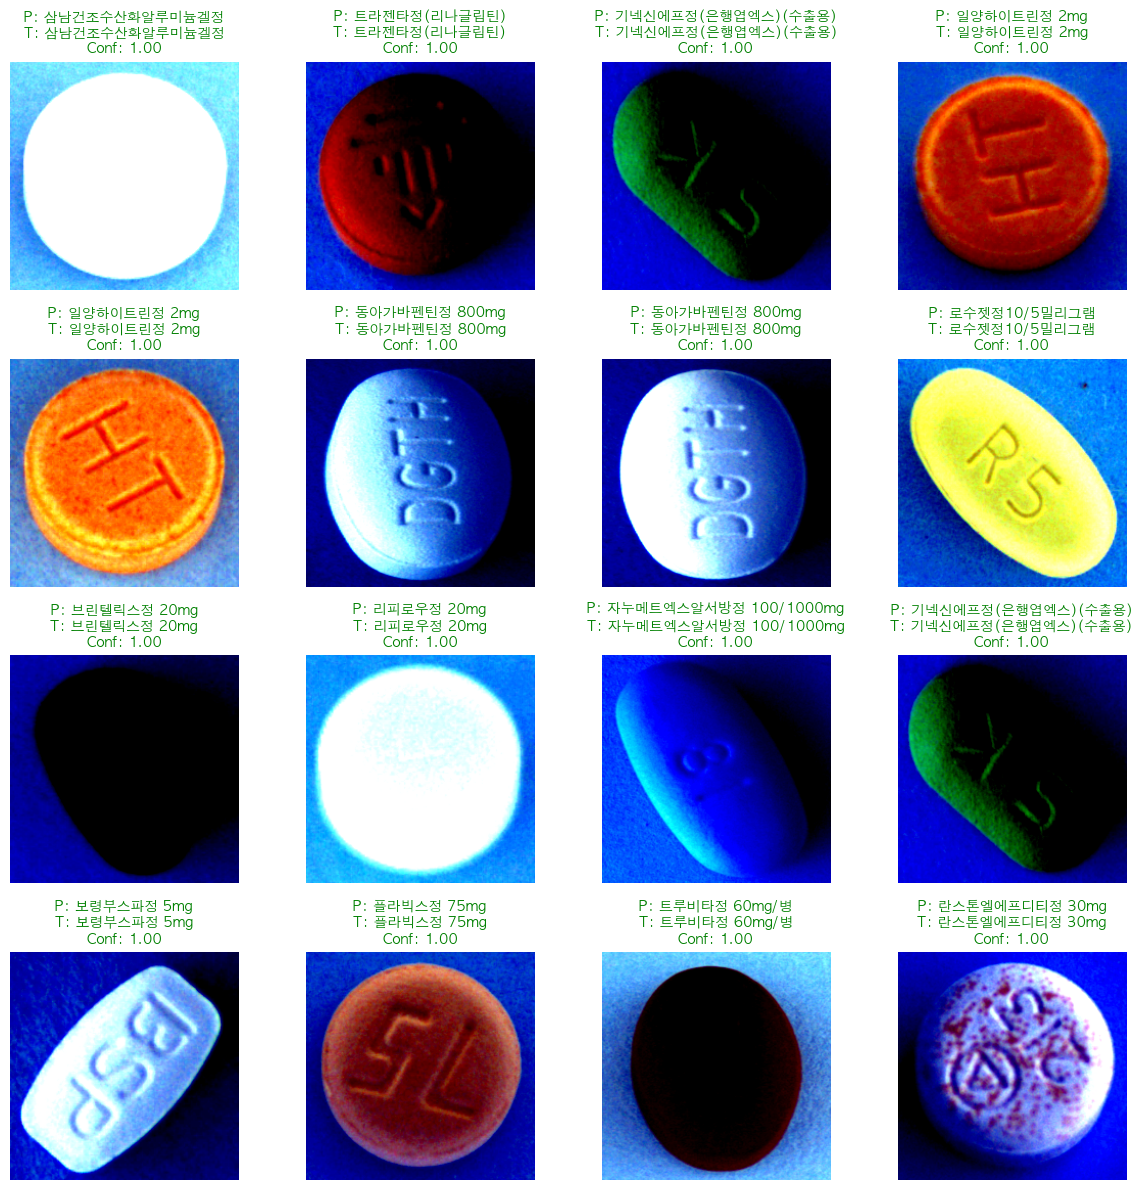

In [55]:
visualize_predictions(resnet101_model, val_dataset, class_names, device, num_images=16)

# 통합하기

In [ ]:
# 단일 이미지 테스트
image_path = "./original/test_images/1.png"
yolo_result = yolov8_model(image_path)[0]

# 탐지된 객체들 순회하며 crop & 분류
for i, box in enumerate(yolo_result.boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cropped_img = Image.open(image_path).crop((x1, y1, x2, y2)).convert("RGB")
    input_tensor = transform_val(cropped_img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = resnet101_model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        prob = torch.softmax(output, dim=1)[0][pred].item()

    print(f"[{i}] Refined Class: {class_names[pred]}, Confidence: {prob:.2f}")


image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images/1.png: 1280x992 4 pills, 309.2ms
Speed: 6.1ms preprocess, 309.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 992)
[0] Refined Class: 울트라셋이알서방정, Confidence: 1.00
[1] Refined Class: 동아가바펜틴정 800mg, Confidence: 1.00
[2] Refined Class: 보령부스파정 5mg, Confidence: 1.00
[3] Refined Class: 놀텍정 10mg, Confidence: 1.00


In [56]:
class_idx_to_name = {0: '가바토파정 100mg',
                    1: '글리아타민연질캡슐',
                    2: '글리틴정(콜린알포세레이트)',
                    3: '기넥신에프정(은행엽엑스)(수출용)',
                    4: '낙소졸정 500/20mg',
                    5: '노바스크정 5mg',
                    6: '놀텍정 10mg',
                    7: '뉴로메드정(옥시라세탐)',
                    8: '다보타민큐정 10mg/병',
                    9: '동아가바펜틴정 800mg',
                    10: '라비에트정 20mg',
                    11: '란스톤엘에프디티정 30mg',
                    12: '레일라정',
                    13: '렉사프로정 15mg',
                    14: '로수바미브정 10/20mg',
                    15: '로수젯정10/5밀리그램',
                    16: '리렉스펜정 300mg/PTP',
                    17: '리리카캡슐 150mg',
                    18: '리바로정 4mg',
                    19: '리피로우정 20mg',
                    20: '리피토정 20mg',
                    21: '마도파정',
                    22: '맥시부펜이알정 300mg',
                    23: '메가파워정 90mg/병',
                    24: '무코스타정(레바미피드)(비매품)',
                    25: '뮤테란캡슐 100mg',
                    26: '보령부스파정 5mg',
                    27: '브린텔릭스정 20mg',
                    28: '비모보정 500/20mg',
                    29: '비타비백정 100mg/병',
                    30: '삐콤씨에프정 618.6mg/병',
                    31: '삼남건조수산화알루미늄겔정',
                    32: '세비카정 10/40mg',
                    33: '스토가정 10mg',
                    34: '신바로정',
                    35: '써스펜8시간이알서방정 650mg',
                    36: '쎄로켈정 100mg',
                    37: '아모잘탄정 5/100mg',
                    38: '아빌리파이정 10mg',
                    39: '아질렉트정(라사길린메실산염)',
                    40: '아토르바정 10mg',
                    41: '아토젯정 10/40mg',
                    42: '알드린정',
                    43: '에빅사정(메만틴염산염)(비매품)',
                    44: '에스원엠프정 20mg',
                    45: '에어탈정(아세클로페낙)',
                    46: '엑스포지정 5/160mg',
                    47: '오마코연질캡슐(오메가-3-산에틸에스테르90)',
                    48: '울트라셋이알서방정',
                    49: '일양하이트린정 2mg',
                    50: '자누메트엑스알서방정 100/1000mg',
                    51: '자누메트정 50/850mg',
                    52: '자누비아정 50mg',
                    53: '자이프렉사정 2.5mg',
                    54: '제미메트서방정 50/1000mg',
                    55: '조인스정 200mg',
                    56: '졸로푸트정 100mg',
                    57: '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0',
                    58: '카나브정 60mg',
                    59: '카발린캡슐 25mg',
                    60: '케이캡정 50mg',
                    61: '콜리네이트연질캡슐 400mg',
                    62: '쿠에타핀정 25mg',
                    63: '큐시드정 31.5mg/PTP',
                    64: '크레스토정 20mg',
                    65: '타이레놀이알서방정(아세트아미노펜)(수출용)',
                    66: '타이레놀정500mg',
                    67: '트라젠타듀오정 2.5/850mg',
                    68: '트라젠타정(리나글립틴)',
                    69: '트루비타정 60mg/병',
                    70: '트윈스타정 40/5mg',
                    71: '펠루비정(펠루비프로펜)',
                    72: '플라빅스정 75mg'}

In [ ]:
# 설정
image_folder = "./original/test_images"  # 테스트 이미지 폴더 경로
output_csv_path = "./results/predicted_samples.csv"

results_folder = Path("./results/visualized_images")
results_folder.mkdir(parents=True, exist_ok=True)

font_path = "/System/Library/Fonts/AppleGothic.ttf"  # Mac OS
# font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows

font_size = 25
font = ImageFont.truetype(font_path, font_size)

# 테스트 이미지 리스트 가져오기 (png))
all_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png'))]

# 랜덤 10개 샘플 선택 (이미지 개수보다 많으면 모두 선택)
sample_images = random.sample(all_images, min(10, len(all_images)))

results = []

for image_name in sample_images:
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    
    # YOLO 추론
    yolo_results = yolov8_model(image)[0]
    boxes = yolo_results.boxes
    
    draw = ImageDraw.Draw(image)
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cropped = image.crop((x1, y1, x2, y2))
        input_tensor = transform_val(cropped).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = resnet101_model(input_tensor)
            prob = torch.softmax(output, dim=1)
            confidence, pred_idx = torch.max(prob, dim=1)
            class_name = class_idx_to_name[pred_idx.item()]
        
        # 바운딩 박스 및 텍스트 그리기 (텍스트는 박스 위에 적당히 띄워서)
        text = f"{class_name} ({confidence.item():.2f})"
        margin_x, margin_y = 5, 5
        
        # 텍스트 크기 계산
        bbox = font.getbbox(text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        text_position = (x1 + margin_x, max(y1 - text_height - margin_y, 0))
        
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.rectangle([text_position, (text_position[0] + text_width, text_position[1] + text_height)], fill="blue")
        draw.text(text_position, text, fill="white", font=font)
        
        # 결과 기록
        results.append({
            "image_name": image_name,
            "object_index": i,
            "bbox": [x1, y1, x2, y2],
            "predicted_class": class_name,
            "confidence": confidence.item()
        })
    
    # 시각화 이미지 저장
    vis_image_path = results_folder / image_name

    image.save(vis_image_path)

# CSV 저장
pd.DataFrame(results).to_csv(output_csv_path, index=False)
print(f"시각화된 이미지들은 '{results_folder}'에 저장됨")
print(f"예측 결과 CSV는 '{output_csv_path}'에 저장됨")

0: 1280x992 4 pills, 333.3ms
Speed: 4.0ms preprocess, 333.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 266.1ms
Speed: 4.5ms preprocess, 266.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 198.7ms
Speed: 3.5ms preprocess, 198.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 200.0ms
Speed: 5.2ms preprocess, 200.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 204.7ms
Speed: 3.6ms preprocess, 204.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 197.0ms
Speed: 4.6ms preprocess, 197.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 4 pills, 185.5ms
Speed: 3.8ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 992)

0: 1280x992 3 pills, 186.9ms
Speed: 3.0ms preprocess, 186.9ms inference, 0.7ms postprocess per im

# Submission

In [66]:
yolov8_model = YOLO("./yolo_model/yolo_weight/002/best.pt")

In [67]:
# {class_id : category id} dic
ClassToCat73 = { 0: 16547, 1: 32309, 2: 33879, 3: 3482, 4: 31704, 5: 19860, 6: 24849,
                7: 3831, 8: 12777, 9: 16550, 10: 21770, 11: 18109, 12: 29450, 13: 29870, 
                14: 38161, 15: 36636, 16: 12080, 17: 18146, 18: 29666, 19: 22073, 20: 16231,
                21: 20013, 22: 22361, 23: 22626, 24: 3543, 25: 2482, 26: 1899, 27: 33877,
                28: 29344, 29: 23222, 30: 6191, 31: 5093, 32: 27652, 33: 19606, 34: 33008,
                35: 13394, 36: 10220, 37: 25468, 38: 12246, 39: 31862, 40: 21324, 41: 35205,
                42: 3742, 43: 13899, 44: 33207, 45: 4542, 46: 20876, 47: 16687, 48: 27925,
                49: 3350, 50: 31884, 51: 25366, 52: 22346, 53: 12419, 54: 34596, 55: 6562,
                56: 27992, 57: 18356, 58: 27776, 59: 41767, 60: 44198, 61: 19231, 62: 23202,
                63: 25437, 64: 16261, 65: 5885, 66: 4377, 67: 30307, 68: 28762, 69: 19551,
                70: 27732, 71: 21025, 72: 20237}

# # 하나씩 당겨준 딕셔너리 생성
# ClassToCat73 = {i - 1: v for i, v in ClassToCat74.items() if i > 0}

# # 결과 확인
# from pprint import pprint
# pprint(ClassToCat73)

In [68]:
TEST_IMAGES = Path("/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images")

In [69]:
# 이미지 리스트
test_images = list(TEST_IMAGES.glob("*.png"))

submission_data = []
annotation_id = 1

for img_path in test_images:
    image = Image.open(img_path).convert("RGB")
    yolo_results = yolov8_model(str(img_path))[0]

    for box in yolo_results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        w, h = x2 - x1, y2 - y1

        cropped_img = image.crop((x1, y1, x2, y2))
        # input_tensor = transform(cropped_img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
        input_tensor = transform_val(cropped_img).unsqueeze(0).to("mps" if torch.backends.mps.is_available() else "cpu")
        with torch.no_grad():
            preds = resnet101_model(input_tensor)
            class_index = torch.argmax(preds, dim=1).item()
            category_id = ClassToCat73[class_index]  # 예측 index를 실제 class_id로 매핑

        confidence = float(box.conf[0].item())

        submission_data.append({
            "annotation_id": annotation_id,
            "image_id": img_path.stem,  # 'im1.png' → 'img_1'
            "category_id": category_id,
            "bbox_x": x1,
            "bbox_y": y1,
            "bbox_w": w,
            "bbox_h": h,
            "score": confidence
        })

        annotation_id += 1

# 저장
submission = pd.DataFrame(submission_data)
submission.to_csv("/Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/submission/submission5_Y002R14.csv", index=False)
print("[완료] submission.csv 저장 완료!  마무으리!")


image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images/1186.png: 1280x992 4 pills, 338.8ms
Speed: 5.7ms preprocess, 338.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 992)

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images/412.png: 1280x992 4 pills, 252.5ms
Speed: 5.0ms preprocess, 252.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 992)

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images/374.png: 1280x992 4 pills, 204.9ms
Speed: 4.2ms preprocess, 204.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 992)

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original/test_images/1192.png: 1280x992 4 pills, 207.8ms
Speed: 4.4ms preprocess, 207.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 992)

image 1/1 /Users/jeonhyejeong/Desktop/Projects/Pills_OD/Pills_OD_02/data/original